<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Model Train and Evaluation: LightGBM   </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the Adults dataset.

[Analysis:](#result)
============
1. Performance metrics for Local and Azure Notebook are different
2. Azure Designer Performance metrics are diffrent with locally trained.


## Contents

1.	[Load prereqs and data](#prereqs)
2.	[Data scale, Train and evaluate a baseline classifier](#classifier)
3.	[Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
pip install lightgbm

In [3]:
%reload_ext watermark
%watermark

2020-11-25T22:11:27+01:00

CPython 3.8.3
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [4]:
# Initialization:
%reload_ext autoreload
%autoreload 2

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,lightgbm

Habtamu desalegn 
last updated: 2020-11-25 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
matplotlib 3.3.3
sklearn 0.23.2
lightgbm 3.1.0


In [6]:
# Downloading the Libraries and Dependencies:
import os
import numpy as np
import pandas as pd
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt

#### Loading the UCI Adult Dataset

In [7]:
""" UCI Adult Dataset (1994 Census)
    https://archive.ics.uci.edu/ml/machine-learning-databases/adult
    features: 14
    examples: 32561
"""

COLUMNS = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                 "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
                 "hours-per-week", "native-country", "income"]
# PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)

df = pd.read_csv('./data/adult.csv', index_col=None)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

new_df = df.loc[:, ~df.columns.isin(['workclass','occupation','native-country'])]
new_df.loc[:,'education'] = le.fit_transform(new_df.loc[:,'education'].values)
new_df.loc[:,'marital-status'] = le.fit_transform(new_df.loc[:,'marital-status'].values)
new_df.loc[:,'relationship'] = le.fit_transform(new_df.loc[:,'relationship'].values)
new_df.loc[:,'race'] = le.fit_transform(new_df.loc[:,'race'].values)
new_df.loc[:,'sex'] = le.fit_transform(new_df.loc[:,'sex'].values)
new_df.loc[:,'income'] = le.fit_transform(new_df.loc[:,'income'].values)

In [9]:
new_df.head()

,age,fnlwgt,education,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,39,77516,9,13,4,1,4,1,2174,0,40,0
1,50,83311,9,13,2,0,4,1,0,0,13,0
2,38,215646,11,9,0,1,4,1,0,0,40,0
3,53,234721,1,7,2,0,2,1,0,0,40,0
4,28,338409,9,13,2,5,2,0,0,0,40,0


In [10]:
X = new_df.drop('income', axis=1).values
y = new_df['income'].values

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [12]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (22792, 11)
y_train.shape: (22792,)
X_test.shape: (9769, 11)
y_test.shape: (9769,)


<a id="classifier"></a>
## 3. Preprocess ,Train and Evaluate a classifier

1. [ModelTraining using Boosted Decision Tree [LightGBM]](#3_1)
2. [Evaluate the model](#3_2)

<a id="3_1"></a>
### 3.1 Training using Boosted Decision Tree [LightGBM]

Train a model using 

In [14]:
# Ref: https://lightgbm.readthedocs.io/en/latest/Parameters.html
#      https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm as lgb
from lightgbm import LGBMClassifier

# set training parameters
params = {
    "boosting_type":'gbdt',     # boosting type, support gbdt for now, alias: boosting, boost
    "objective": "binary",      # binary , binary classification task
    "learning_rate": 0.2,       # shrinkage rate
    "n_estimators":  100,        #n_estimators (int, optional (default=100)) – Number of boosted trees to fit.
    "num_leaves": 20,           # number of leaves for one tree
    "min_child_samples": 10,    # min_child_samples (int, optional (default=20)) – Minimum number of data needed in a child (leaf).
    "metric": "binary_logloss", # binary_logloss , default metric for binary
    "random_state": 42
}

MODEL = "LGBMClassifier"
model = LGBMClassifier(boosting_type = params["boosting_type"], 
                     objective = params["objective"],
                     learning_rate = params["learning_rate"],                  
                     num_leaves = params["num_leaves"], 
                     min_child_samples = params["min_child_samples"],
                     metric = params["metric"],
                     random_state = params["random_state"],
                     n_estimators = params["n_estimators"])
model.fit(X_train, y_train)
print(f"model: {model}")

model: LGBMClassifier(learning_rate=0.2, metric='binary_logloss', min_child_samples=10,
               num_leaves=20, objective='binary', random_state=42)


<a id="2_3"></a>
## 4. Evaluate the model

Looking at different performance evaluation metrics

In [15]:
from sklearn import metrics

# log_loss
y_proba = model.predict(X_test)
loss = metrics.log_loss(y_test, y_proba)
print(f"log_loss: {loss}")

# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")

print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

# Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred)
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))


log_loss: 4.7058545183335365
y_pred: [0 0 1 ... 0 0 1]
Misclassified examples:1331
confusion matrix:
 [[6978  477]
 [ 854 1460]]
auc: 0.7834790940978629
Accuracy: 0.8637526870713481
Precision: 0.7537429013939081
Recall: 0.6309420916162489
F1: 0.6868972006586685
classification_report
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      7455
           1       0.75      0.63      0.69      2314

    accuracy                           0.86      9769
   macro avg       0.82      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769



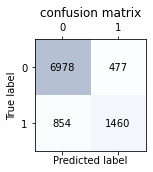

In [16]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [17]:
import joblib
joblib.dump(model, f"models/local/adult/{MODEL}.pkl")

['models/local/adult/LGBMClassifier.pkl']

#### Model Trained using Azure Notebook

use to predict

In [19]:
import joblib
clf = joblib.load("./models/azure-adult/adult_LightGBM.pkl")
print(f"model: {clf}")

# Evaluate model
from sklearn import metrics

# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (clf.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")

print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

model: LGBMClassifier(learning_rate=0.2, metric='binary_logloss', min_child_samples=10,
               num_leaves=20, objective='binary', random_state=42)
y_pred: [0 0 1 ... 0 0 1]
Misclassified examples:1317
confusion matrix:
 [[7006  449]
 [ 868 1446]]
Accuracy: 0.8651857917903573


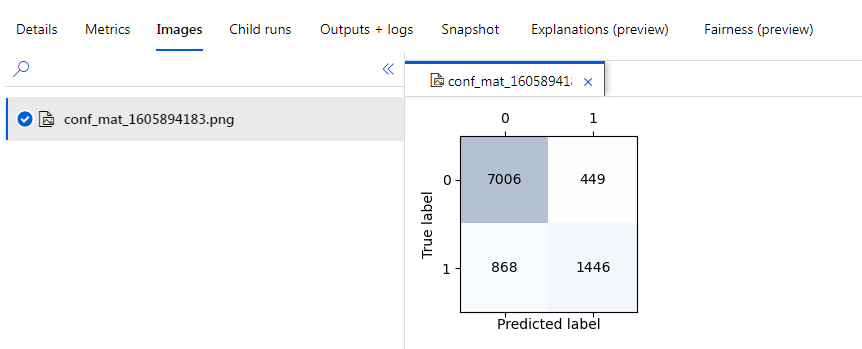

In [79]:
Image(filename='images/Azure/Exp-2/lightGBM/conf_mat.png')

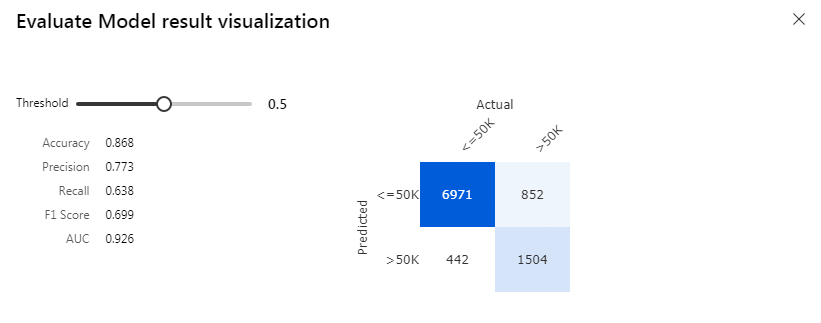

In [80]:
Image(filename='images/Azure/Exp-2/lightGBM/designer-metrics.png') 

#### Transformed (Designer)

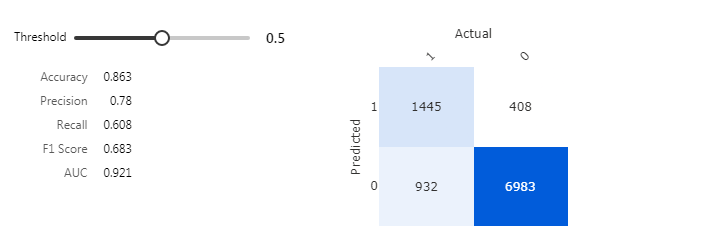

In [81]:
Image(filename='images/Azure/Exp-2/lightGBM-2/metrics-designer.png')

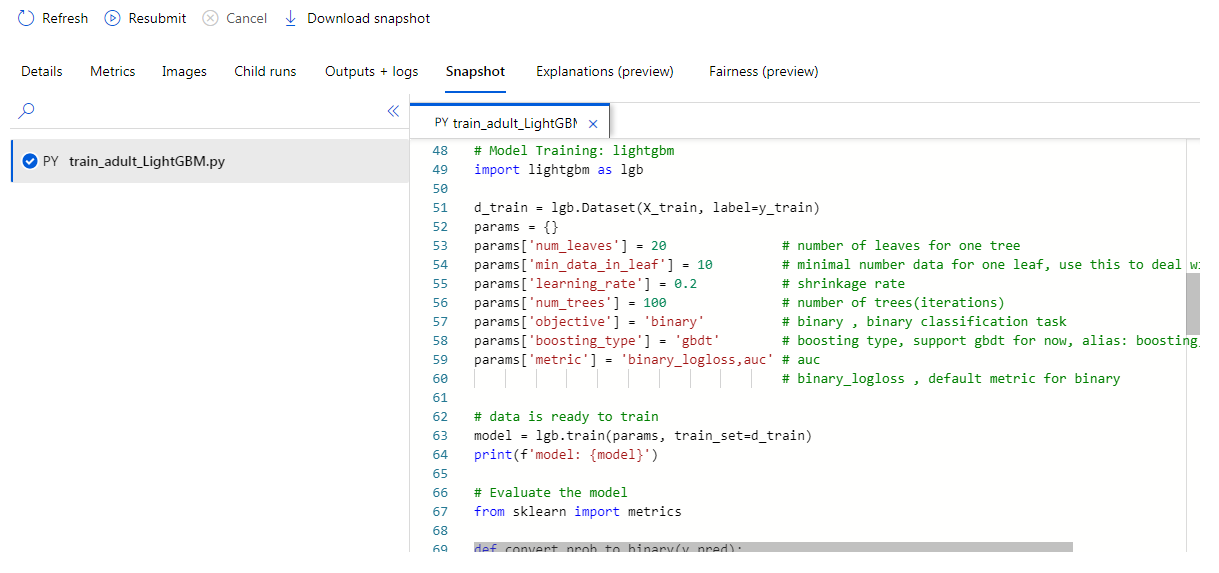

In [82]:
Image(filename='images/Azure/Exp-2/lightGBM/snapshot.png')

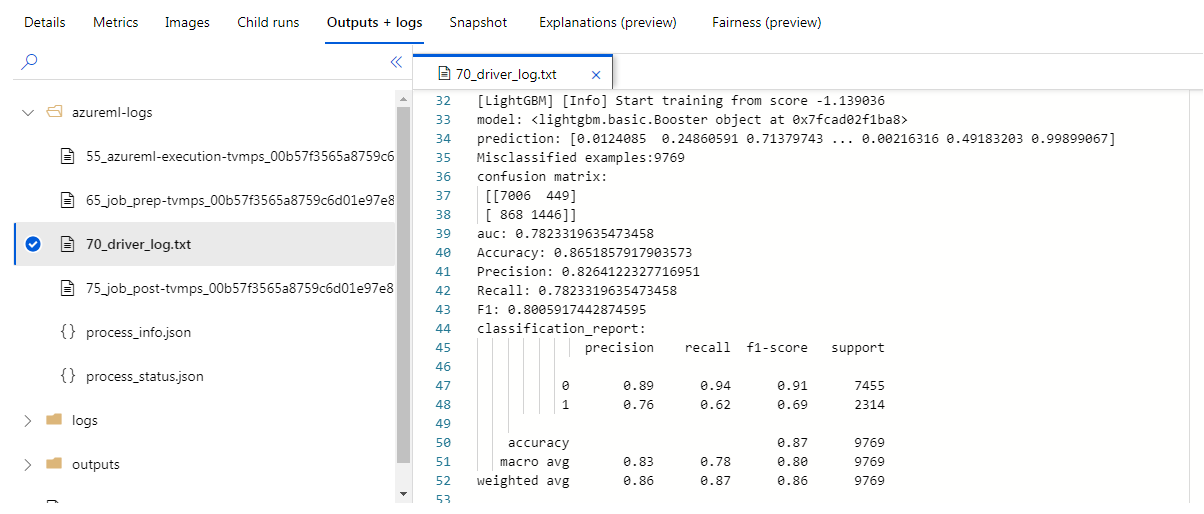

In [83]:
Image(filename='images/Azure/Exp-2/lightGBM/driver_log.png')

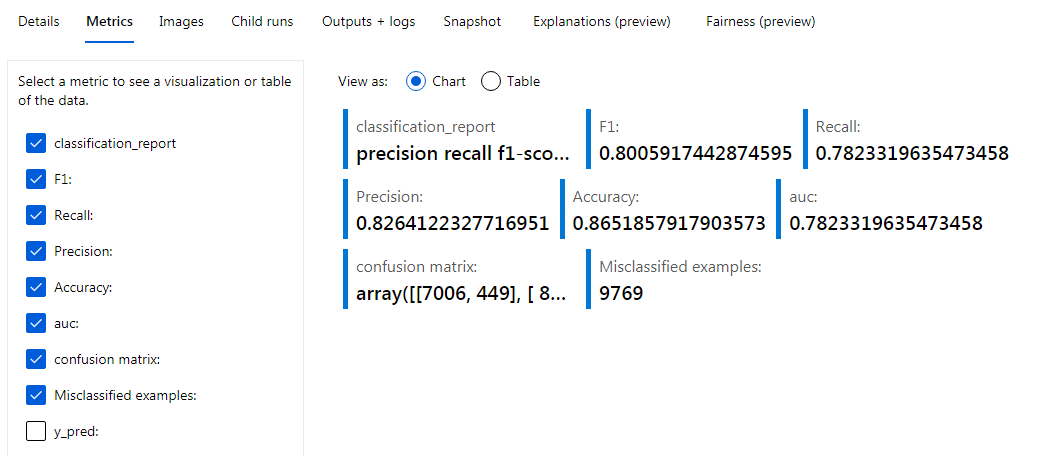

In [84]:
Image(filename='images/Azure/Exp-2/lightGBM/metrics.png')

#### Transformed (Designer)

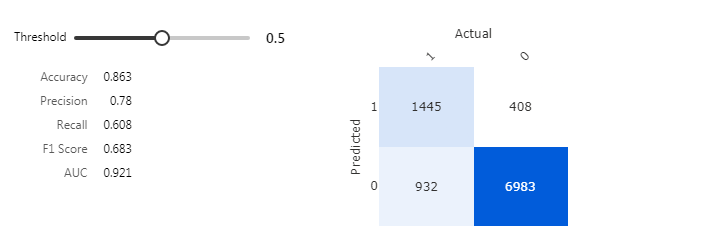

In [85]:
Image(filename='images/Azure/Exp-2/lightGBM-2/metrics-designer.png') 

In [86]:
import joblib
MODEL = 'lightgbm'
joblib.dump(model, f"models/local/{MODEL}.pkl")

['models/local/lightgbm.pkl']

<a id="result"></a>
## 5 Result comparison

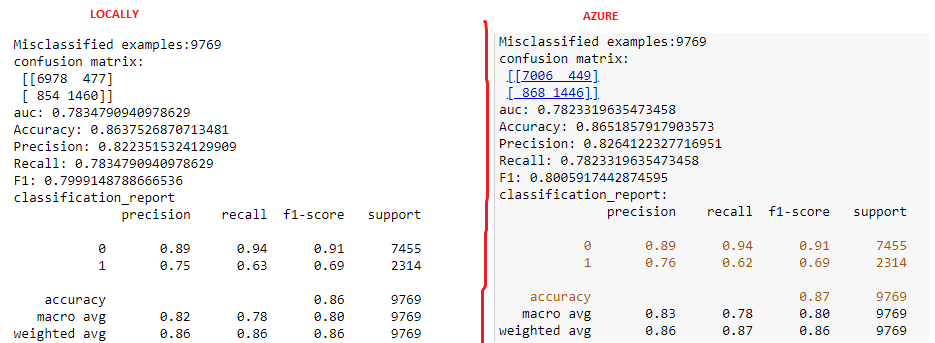

In [87]:
Image(filename='images/Azure/Exp-2/lightGBM/result.png') 

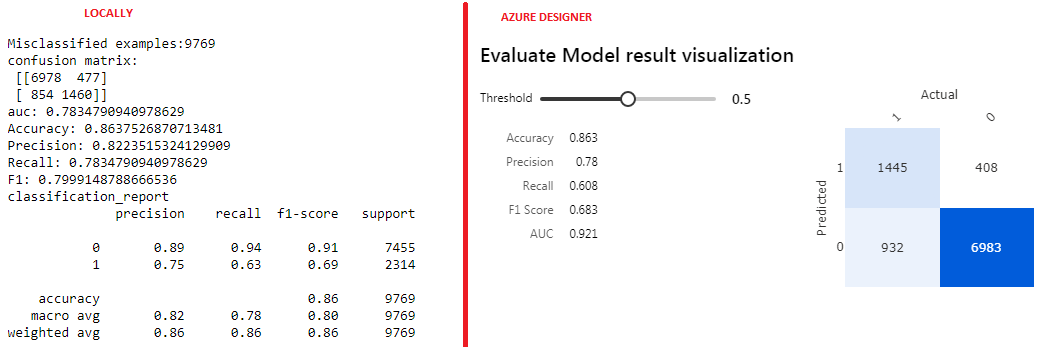

In [88]:
Image(filename='images/Azure/Exp-2/lightGBM-2/metrics-designer-comparison.png')

## Designer

https://docs.microsoft.com/en-us/azure/machine-learning/algorithm-module-reference/two-class-boosted-decision-tree

### Option 1

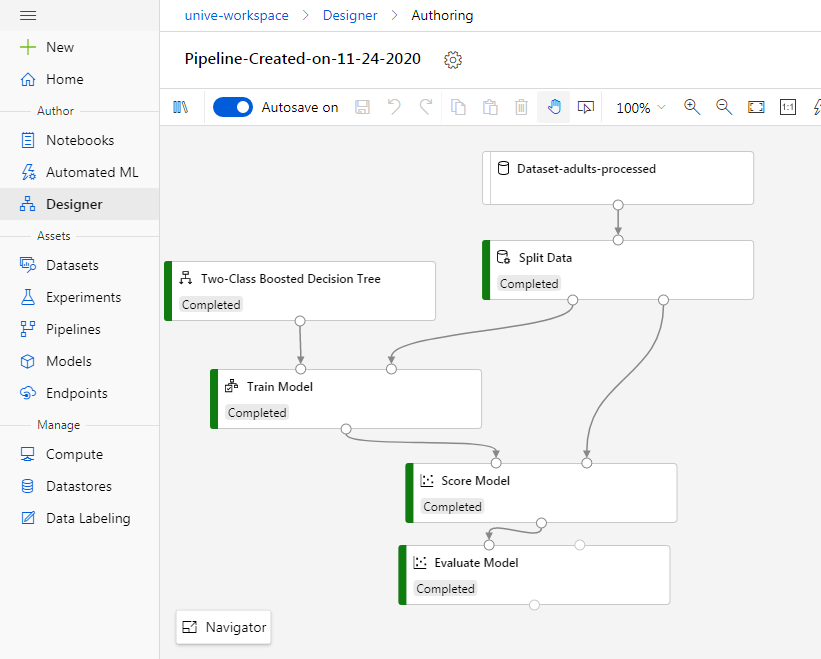

In [20]:
from IPython.display import Image
Image(filename='images/Azure/Exp-2/lightGBM/0-pipeline.png')

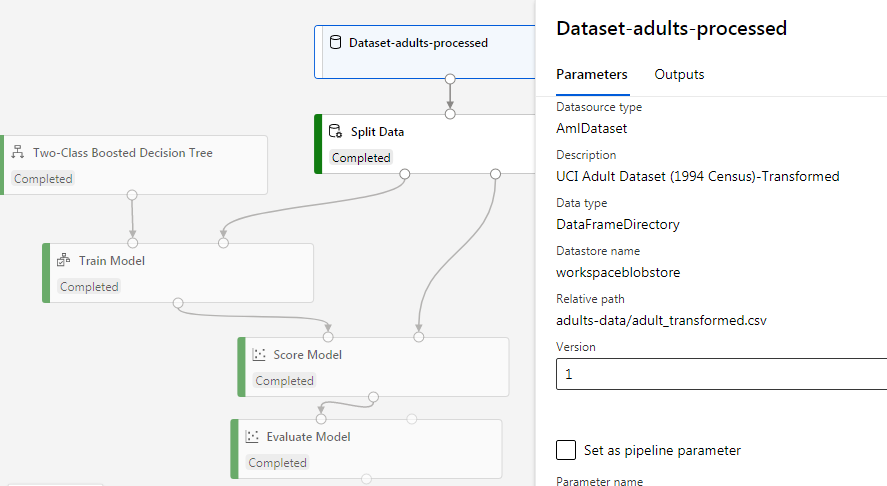

In [21]:
Image(filename='images/Azure/Exp-2/lightGBM/1-dataset.png')

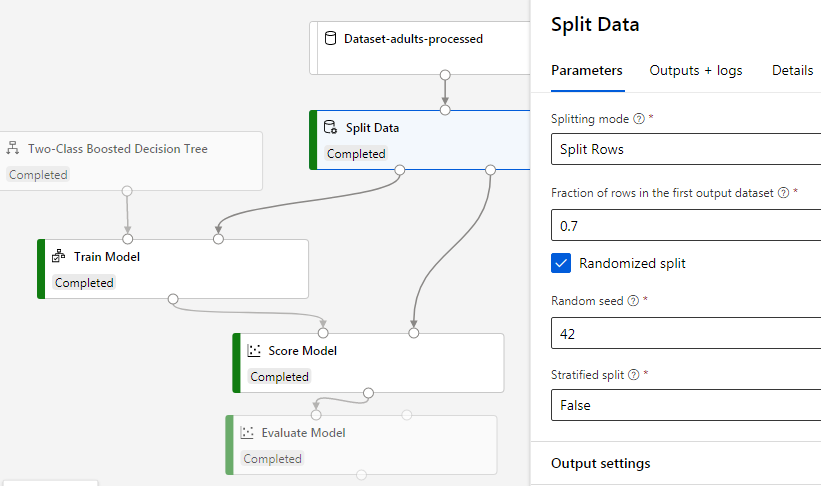

In [22]:
Image(filename='images/Azure/Exp-2/lightGBM/2-split.png')

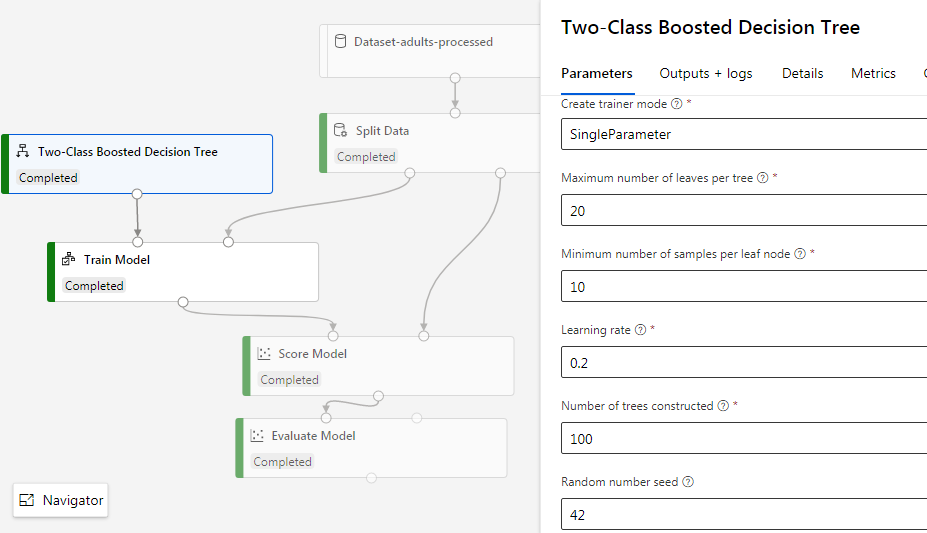

In [23]:
Image(filename='images/Azure/Exp-2/lightGBM/3-classifier.png')

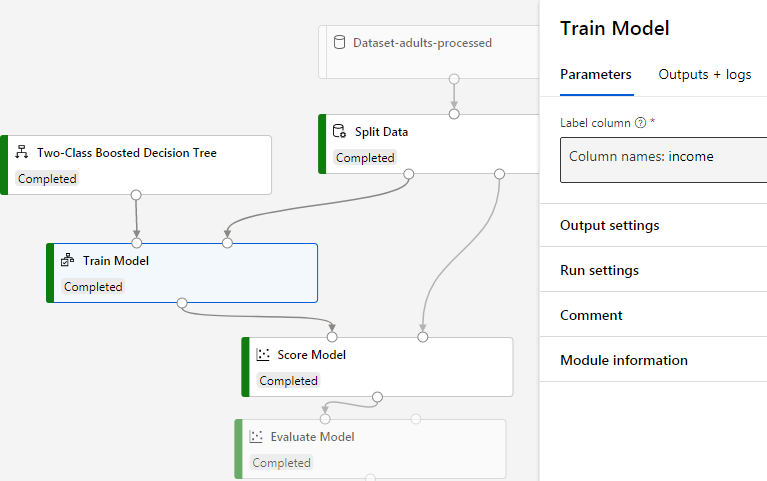

In [24]:
Image(filename='images/Azure/Exp-2/lightGBM/4-trainmodel.png')

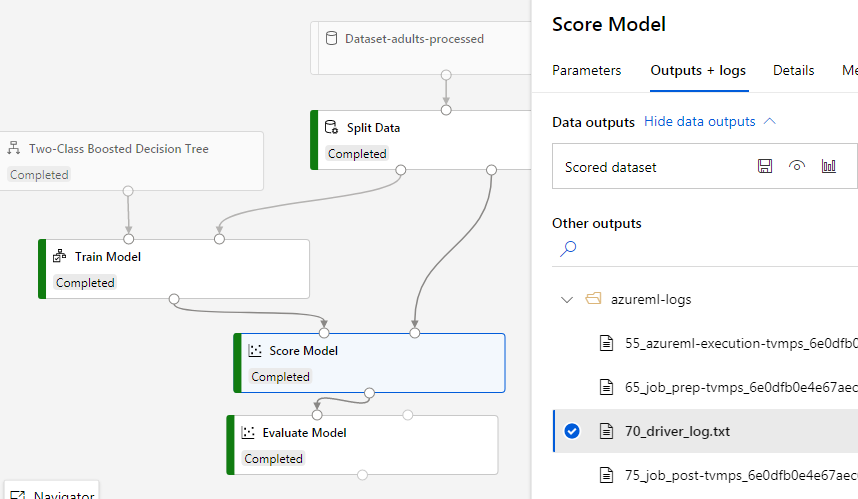

In [25]:
Image(filename='images/Azure/Exp-2/lightGBM/5-scoremodel.png')

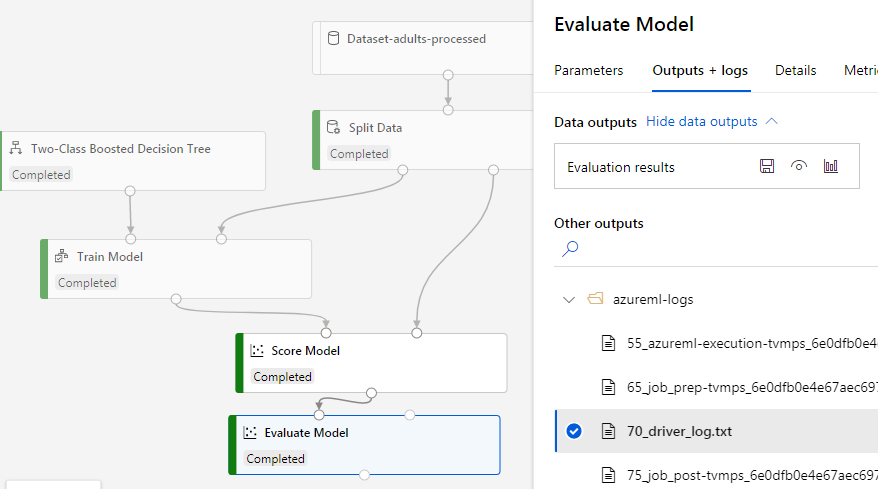

In [26]:
Image(filename='images/Azure/Exp-2/lightGBM/6-evaluatemodel.png')

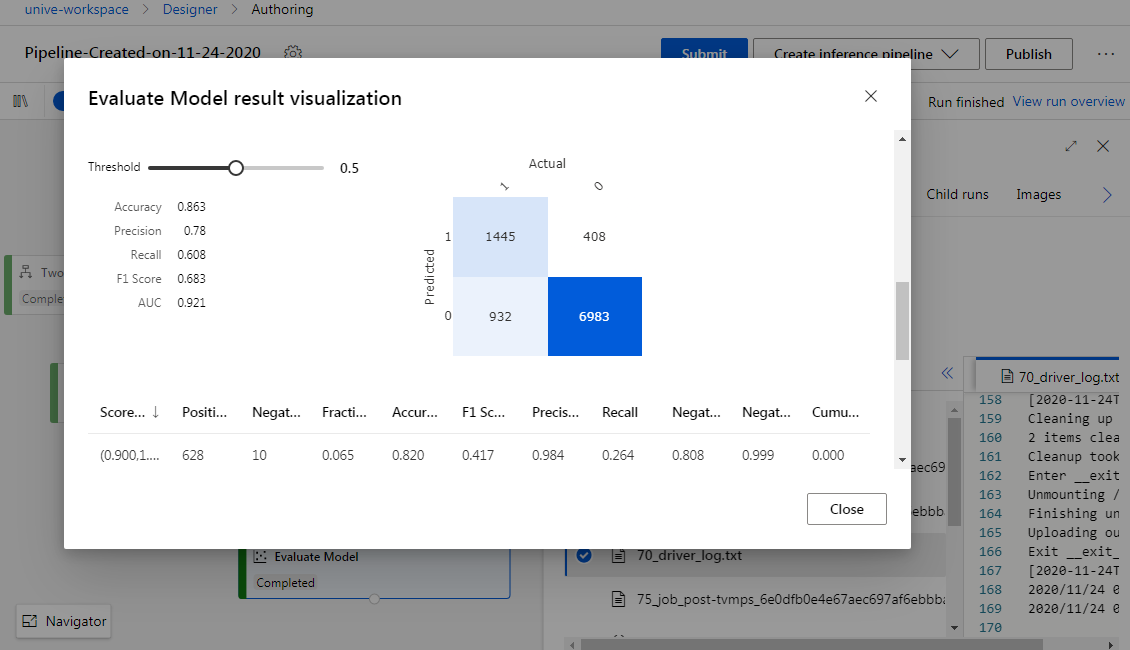

In [27]:
Image(filename='images/Azure/Exp-2/lightGBM/6-evaluatemodel-2.png')

### Option 2

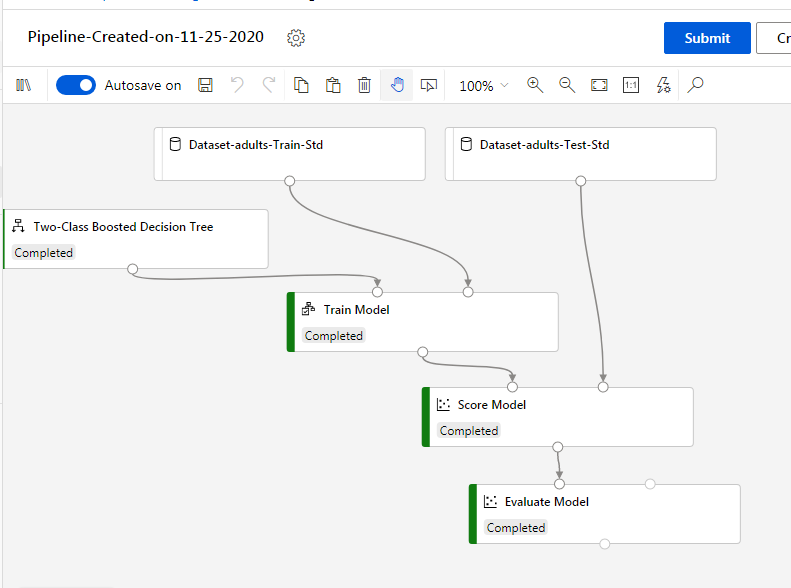

In [28]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/0-pipeline.png')

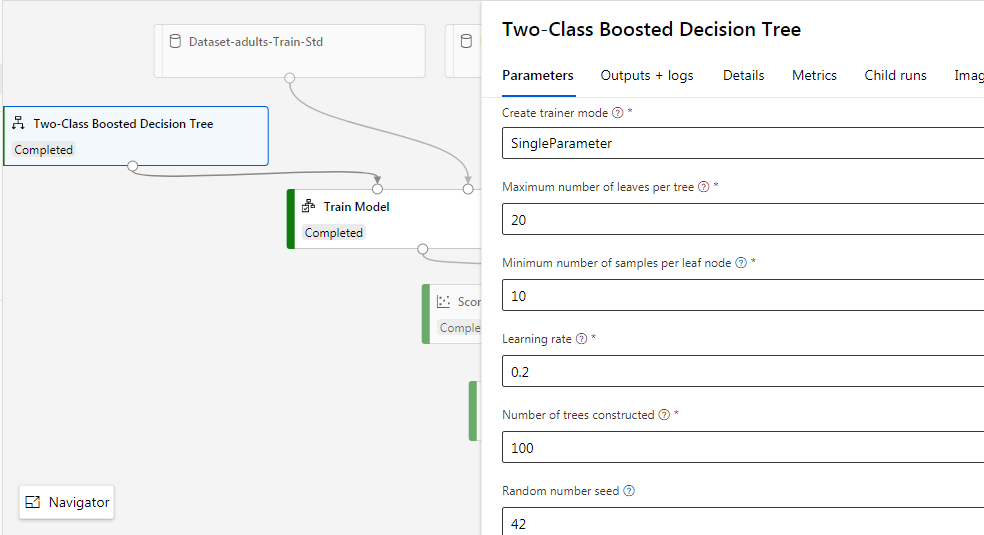

In [29]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/1-classify.png')

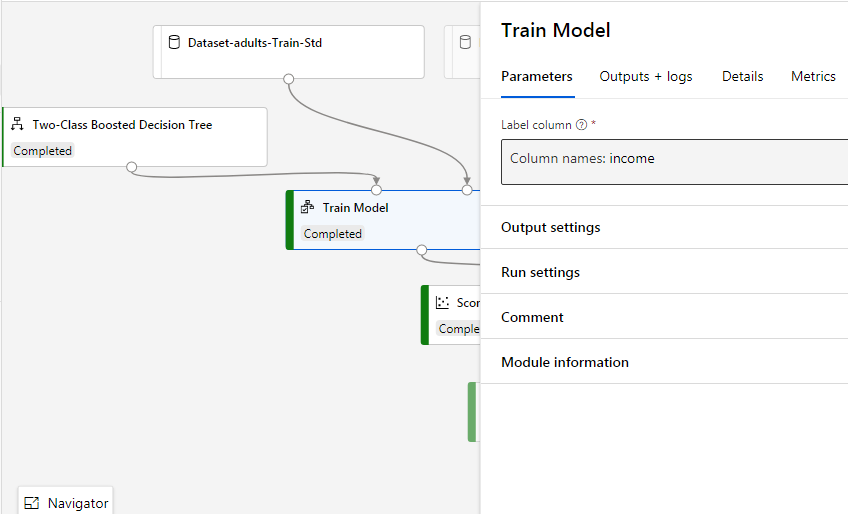

In [30]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/2-Train.png')

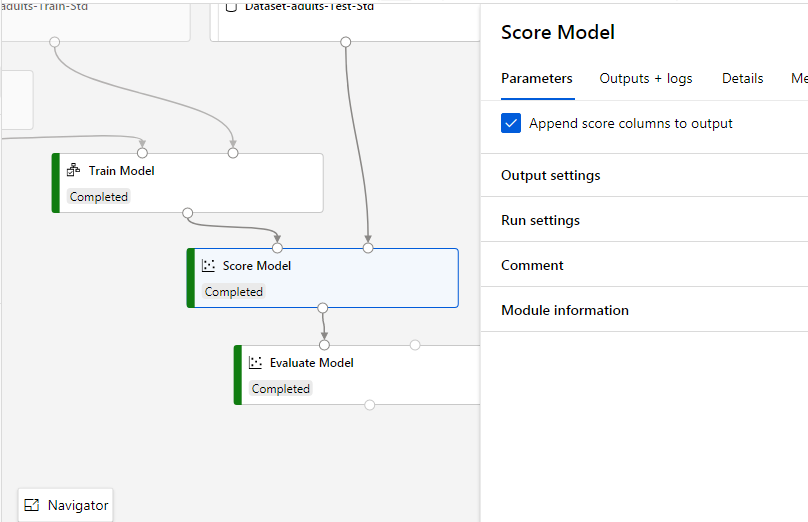

In [31]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/3-score.png')

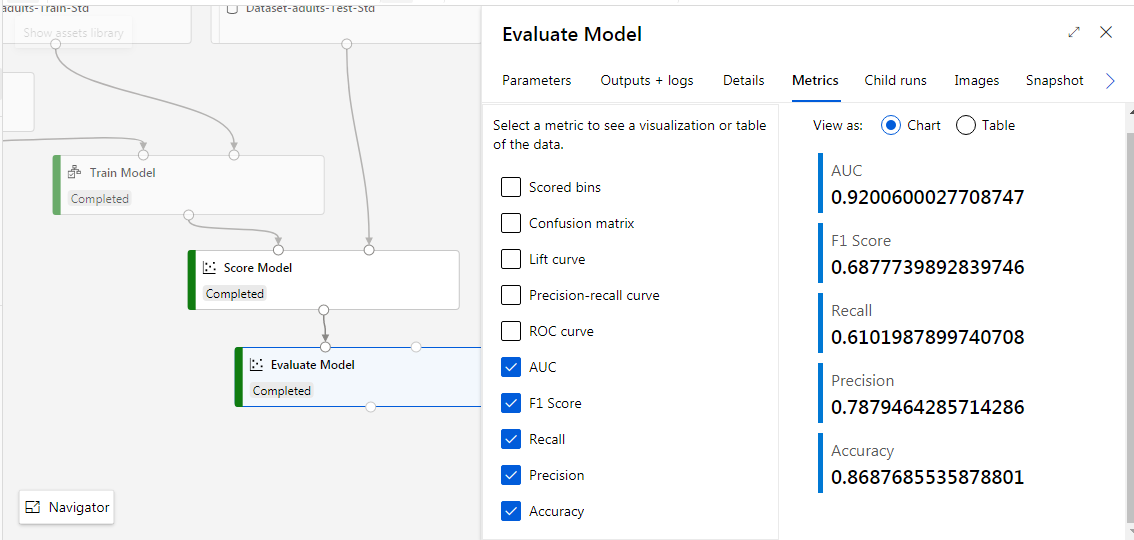

In [32]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/4-evaluate.png')

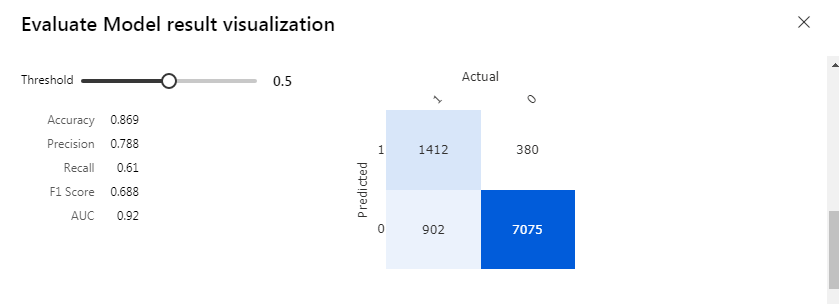

In [33]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/5-evaluate-1.png')

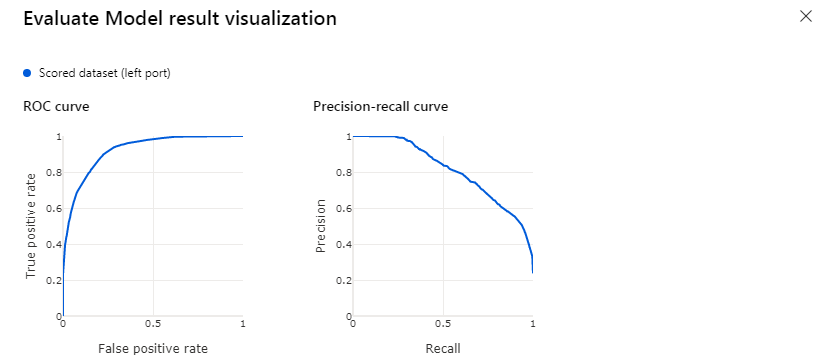

In [34]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/5-evaluate-2.png')

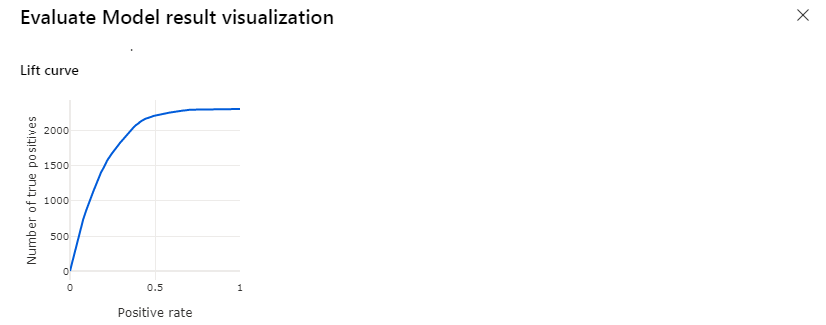

In [35]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/5-evaluate-3.png')

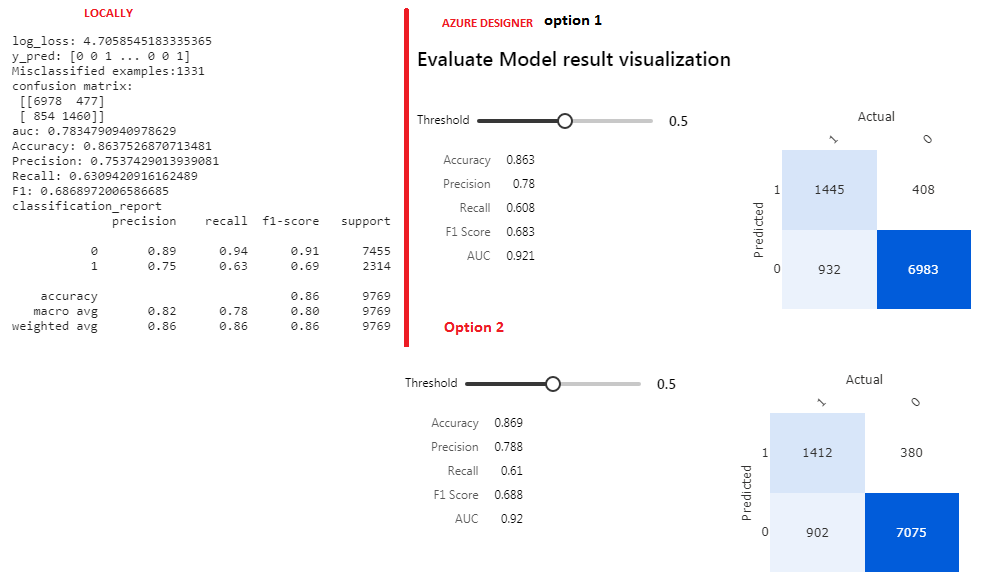

In [36]:
Image(filename='images/Azure/Exp-2/lightGBM/opt2/result.png')

## 6 Adversarial-Robustness-Toolbox for Lightgbm